In [1]:
import numpy as np
from ipypublish import nb_setup
from buildingspy.io.outputfile import Reader
from os.path import join
from random import randint
import seaborn as sns
from scipy import integrate

In [2]:
pd = nb_setup.setup_pandas()
plt = nb_setup.setup_matplotlib()

In [3]:
sns.set(style='whitegrid')

# Artificial pulse - Simulations of random test samples

In [4]:
path_test = '/media/maousi/Data/tmp/simulation_LVAD_RPM{}_Pulse_T30_N2000_2020_04_26/dnn_test_2020_06_17/outputs'
paths_test = {rpm: path_test.format(rpm) for rpm in [4000, 5000, 6000]}

file_name_exact = 'Ursino1998Model_VAD2_output_{}_exact.mat'

In [5]:
# Define: variables to load
variables = ['SystemicArteries.PC', 'AorticValve.Inlet.Q',
             'SystemicArteries.Inlet.Q', 'LVAD.RPM', 'LeftVentricle.Inlet.P']

In [6]:
def time_range(tmin, tmax, t, signal):
    ids = np.where(np.logical_and(t >= tmin, t <= tmax))
    return t[ids], signal[ids]

In [7]:
# Load random simulations 
data_test = {}
tmin, tmax = 20.0, 30.0
for rpm, path in paths_test.items():
    file = join(path, file_name_exact.format(randint(0, 500)))
    print('Loading {}...'.format(file))
    reader = Reader(file, 'dymola')
    data_test[rpm] = [
        time_range(tmin, tmax, *reader.values(var)) for var in variables
    ]

Loading /media/maousi/Data/tmp/simulation_LVAD_RPM4000_Pulse_T30_N2000_2020_04_26/dnn_test_2020_06_17/outputs/Ursino1998Model_VAD2_output_274_exact.mat...
Loading /media/maousi/Data/tmp/simulation_LVAD_RPM5000_Pulse_T30_N2000_2020_04_26/dnn_test_2020_06_17/outputs/Ursino1998Model_VAD2_output_328_exact.mat...
Loading /media/maousi/Data/tmp/simulation_LVAD_RPM6000_Pulse_T30_N2000_2020_04_26/dnn_test_2020_06_17/outputs/Ursino1998Model_VAD2_output_194_exact.mat...


In [8]:
def plot_simulations(data_hf):
    fig, ax = plt.subplots(len(data_hf), 1, figsize=(10, 10))

    for i, (rpm_c, data) in enumerate(data_hf.items()):
        ax1 = ax[i]
        ax2 = ax1.twinx()

        (t1, pressure), (t2, valve_flow), (t3, aortic_flow), (t4, rpm), (t5, lv_pressure) = data
        #(t1, pressure), (t2, valve_flow), (t3, arotic_flow), (t4, rpm) = data[0], data[1], data[2], data[3]
        ax1.plot(t4, rpm/100, 'k--', linewidth=1)
        ax1.plot(t1, pressure, 'b')
        ax1.plot(t1, lv_pressure, '--', linewidth=0.5)
        ax2.plot(t2, valve_flow, 'g--', linewidth=1)
        ax2.plot(t3, aortic_flow, 'r')
        #ax2.set_ylim([min(flow)-25, max(flow)+25])
        #ax1.set_ylim(-5, max(max(pressure), max(flow)))
        #ax2.plot(t2, flow)

        # Manage x axis
        if i == 2:
            ax1.set_xlabel('Time [s]')
        else:
            pass#ax1.set_xticks([])
        
        ax1.set_ylabel('Systemic pressure [mmHg]\nLV pressure [mmHg]\nPump speed [RPM/100]')
        ax2.set_ylabel('Aortic flow [ml/s]\nValve flow [ml/s]')
        #ax1.yaxis.label.set_color('b')
        # Align the grids
        #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
        ax2.grid(False)
        ax2.set_ylim([-5, 1.5*max(aortic_flow)])
        #ax1.set_title('RPM mean = {}'.format(rpm_c))

    plt.subplots_adjust(hspace=.2)

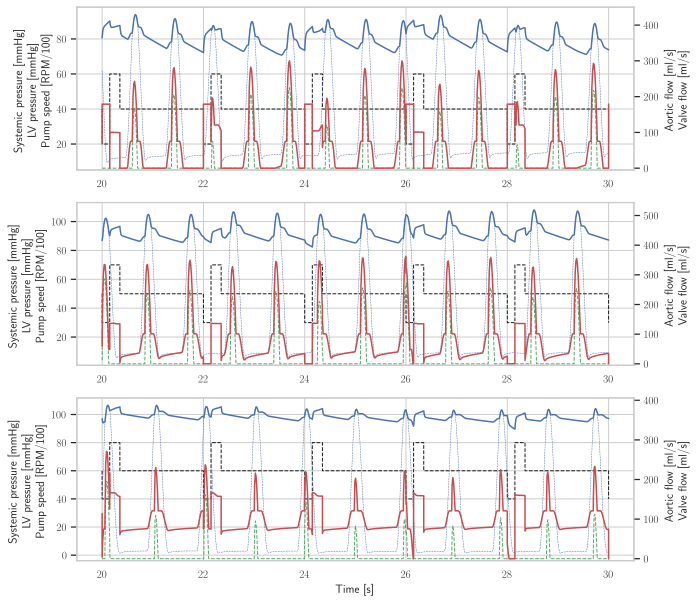

In [9]:
plot_simulations(data_test)

# Reminder of the problem

Reminder: we have 6 data sets,

1. Artificial pulse
    1. RPM = 4000
    1. RPM = 5000
    1. RPM = 6000
1. *No* artificial pulse
    1. RPM = 4000
    1. RPM = 5000
    1. RPM = 6000

Each of these is splitted into a training set (9500 samples) and a test set (500 samples). On figure 1.1, we visualize the samples from the test set for simplicity.

When *no* artificial pulse is present, we observe a clear difference between the different pump speed levels (this is not shown here). This is not the case when we activate pump speed modulation, which is a problem since this is not physiologically relevant:

In [10]:
def filter_unique(t, v):
    t_unique_idx = np.unique(t, return_index=True)[1]
    return t[t_unique_idx], v[t_unique_idx]

In [11]:
def mean_trpz(time, val):
    """Compute the mean of the given signal by performing trapezoidal integration,
    this is better than np.mean() since it does not assume that points are evenly-spaced in time."""
    dt = max(time) - min(time)
    return integrate.trapz(val, time) / dt

In [12]:
def compute_mean(file_path, variable, tmin, tmax, unique=True):
    t, v = Reader(file_path, 'dymola').values(variable)
    
    t, v = time_range(tmin, tmax, t, v)
    
    if unique:
        t, v = filter_unique(t, v)
    
    return mean_trpz(t, v)

In [13]:
test_set_file_exact_format = 'Ursino1998Model_VAD2_output_{}_exact.mat'
test_set_N_file = 500

In [14]:
# Load data and compute mean pressure
pressures = {}
for rpm, path in paths_test.items():
    # Load each file and compute mean SAP
    data = {}
    for i in range(test_set_N_file):
        file = join(path, test_set_file_exact_format.format(i))
        MSAP = compute_mean(file, 'SystemicArteries.PC', 20.0, 30.0)
        data[i] = MSAP
        if i % 10 == 0: print(i, end=',')
    pressures[rpm] = data

0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,

In [15]:
# Load the simulation parameters of those test samples
y_param_names = ['Emax', 'Emax0', 'G_Emax', 'k_E']
y_exact_paths = {rpm: join(path, '../../dnn/Ytest.txt') 
                 for rpm, path in paths_test.items()}

Y = {}
for rpm, file in y_exact_paths.items():
    df = pd.read_csv(file, header=None, sep=' ')
    df.columns = y_param_names
    Y[rpm] = df

In [16]:
# Merge the Y params with the mean SAP
for rpm, df in Y.items():
    p_data = sorted(pressures[rpm].items(), key=lambda e: e[0])
    p_data = [e[1] for e in p_data]
    df['MSAP'] = p_data
    df['RPM'] = rpm

In [17]:
MSAP = pd.concat(Y.values(), ignore_index=True)

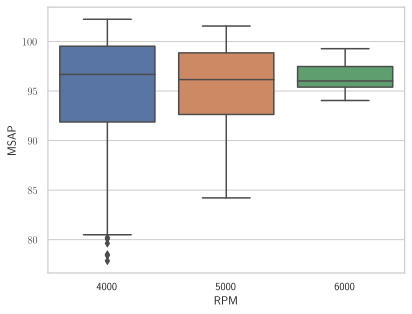

In [18]:
sns.boxplot(x='RPM', y='MSAP', data=MSAP)

The code of figure 1.1 is not the same as the code for figure 1.2. This is simply to confirm that something is wrong with the datasets having artificial pulse activated. 

## Reminder: post-processing values of all datasets


In [19]:
from IPython.display import Image

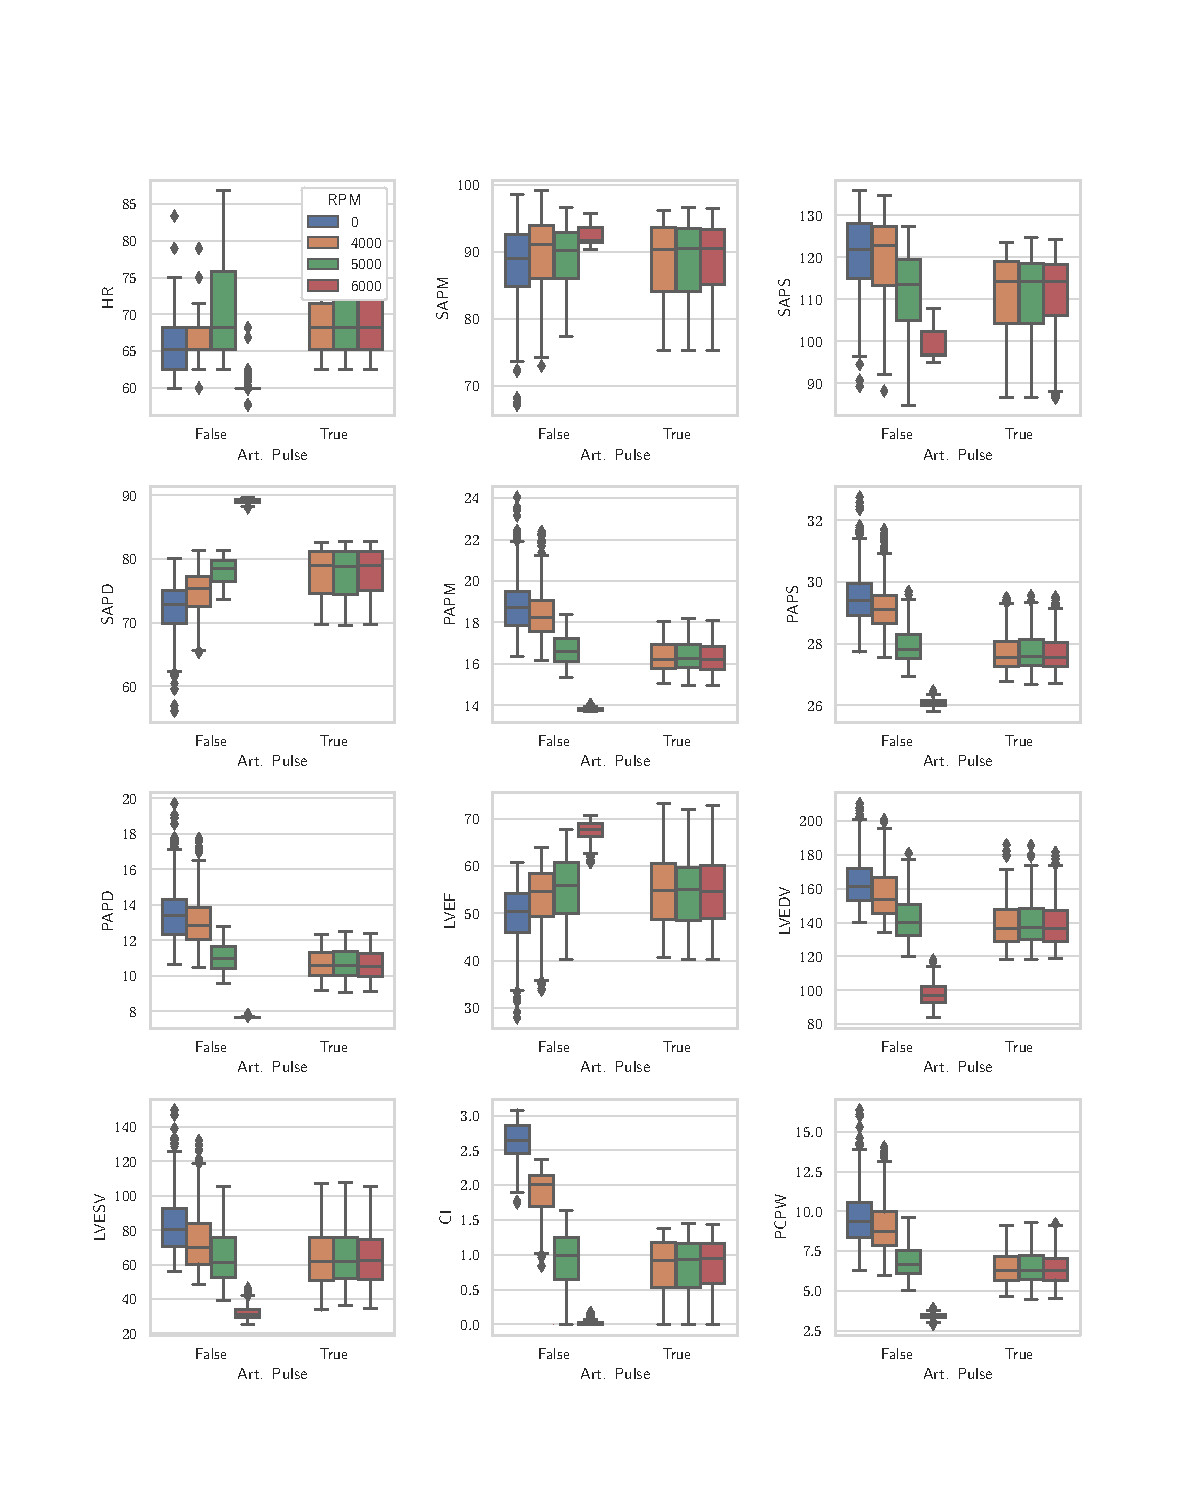

In [20]:
Image('figs/test_sim_dist.jpg')

Figures 1.1 and 1.2 do not show the exact same values for mean systemic arterial pressures (MSAP in figure 1.1, SAPM in figure 1.2). This is because:

* Figure 1.1 computes $\bar P_{art} = \frac{1}{3} P_{systole} + \frac{2}{3} P_{diastole}$ over the last cardiac cycle
* Figure 1.2 comptues $\bar P_{art}$ with trapezoidal integration between 20-30 seconds

## PCA

In [21]:
from sklearn.decomposition import PCA

In [22]:
MSAP_pca = MSAP.drop(['RPM', 'MSAP'], axis=1)

In [23]:
pca = PCA()
X = pca.fit(MSAP_pca).transform(MSAP_pca)

In [24]:
pca.explained_variance_ratio_

array([6.07053594e-01, 3.86786558e-01, 6.15909118e-03, 7.56538668e-07])

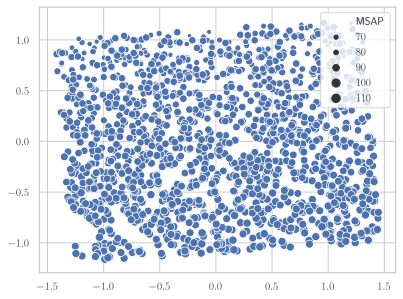

In [25]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], size=MSAP['MSAP'])

# Compare pressures on particular cases

Let's compare the systemic arterial pressures for different configurations, each being a combination of:

* Heart failure level (severe, medium, healthy)
* Pump speed (4000, 5000, 6000)
* With/without artificial pulse

=> 3 * 3 * 2 = 18 possibile configurations.

In [26]:
# Data structure: dictionnary (hf_level, rpm, art_pulse): (time, var)
# - hf_level: SHF, MHF, HH
# - rpm: 4000, 5000, 6000
# - art_pulse: True / False

In [27]:
path_case_study = '/media/maousi/Data/tmp/case_study'
file_format = 'Ursino1998Model_VAD2_AP_{}_RPM_{}_HF_{}.csv'

In [28]:
files = {
    (ap, rpm, hf): file_format.format(ap, rpm, hf)
    for ap in [True, False]
    for rpm in [4000, 5000, 6000]
    for hf in ['SHF', 'MHF', 'HH']
}

In [29]:
data = {}
for config, file in files.items():
    file_path = join(path_case_study, file)
    df = pd.read_csv(file_path)
    t, v = (df.time.values, df['SystemicArteries.Inlet.P'].values)
    t, v = time_range(20.0, 30.0, t, v)
    data[config] = (t,v)

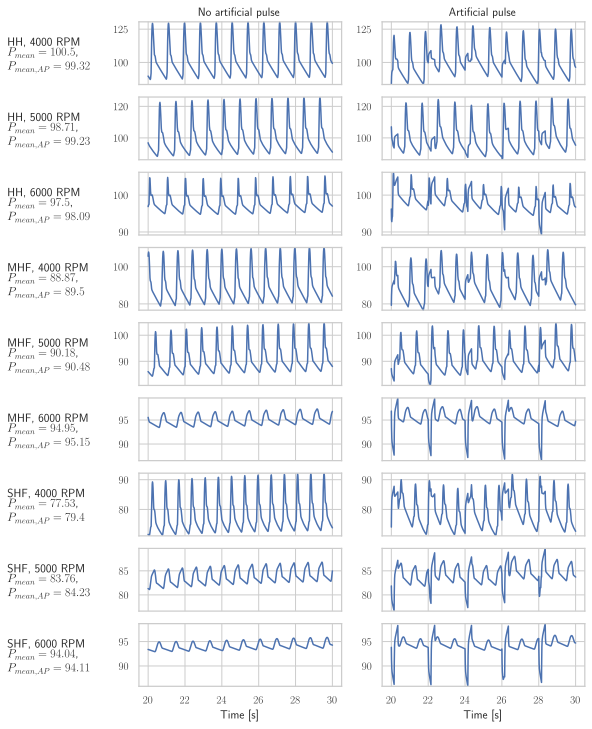

In [30]:
fig, ax = plt.subplots(9, 2, figsize=(8, 12))

iter_idx = [(rpm, hf)for hf in ['HH', 'MHF', 'SHF'] for rpm in [4000, 5000, 6000] ]

for i, (rpm, hf) in enumerate(iter_idx):
    # Extract data and plot
    t, p = filter_unique(*data[(False, rpm, hf)])
    t_ap, p_ap = filter_unique(*data[(True, rpm, hf)])
    
    ax[i][0].plot(t, p)
    ax[i][1].plot(t_ap, p_ap)
    
    # Align y axes of both figures
    pressure_lims = [
        min(min(p), min(p_ap)), max(max(p), max(p_ap))
    ]
    ax[i][0].set_ylim(pressure_lims)
    ax[i][1].set_ylim(pressure_lims)
    
    # Mean pressure
    mean_p = mean_trpz(t, p)
    mean_p_ap = mean_trpz(t_ap, p_ap)
    
    # Print description
    desc = f'{hf}, {rpm} RPM\n'
    desc += '$P_ {{mean}} = {:.4}$,\n$P_{{mean,AP}} = {:.4}$'.format(mean_p, mean_p_ap)
    ax[i][0].text(-0.65,0.2, desc, transform=ax[i][0].transAxes)

    # Cosmetics
    if i < 8:
        ax[i][0].set_xticklabels([])
        ax[i][1].set_xticklabels([])
    else:
        ax[i][0].set_xlabel('Time [s]')
        ax[i][1].set_xlabel('Time [s]')
    
    if i == 0:
        ax[i][0].set_title('No artificial pulse')
        ax[i][1].set_title('Artificial pulse')

plt.savefig('figs/pressure_case_study.eps', bbox_inches = "tight")

## Mean pressures

In [31]:
df = pd.DataFrame(columns=['AP', 'RPM', 'HF', 'MSAP'])

In [32]:
for i, ((ap, rpm, hf), (t, p)) in enumerate(data.items()):
    df.loc[i] = [ap, rpm, hf, mean_trpz(t, p)]

In [33]:
from pandas.plotting import scatter_matrix

In [34]:
df

,AP,RPM,HF,MSAP
0,True,4000,SHF,79.403106
1,True,4000,MHF,89.499274
2,True,4000,HH,99.318241
3,True,5000,SHF,84.229866
4,True,5000,MHF,90.480463
5,True,5000,HH,99.230854
6,True,6000,SHF,94.112737
7,True,6000,MHF,95.153896
8,True,6000,HH,98.094245
9,False,4000,SHF,77.525450


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


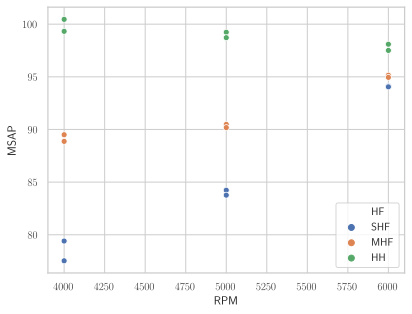

In [35]:
sns.scatterplot(x='RPM', y='MSAP', hue='HF', data=df)
plt.savefig('figs/pressure_case_study_2.eps')

# Distribution of randomly sampled HF parameters

The parameter values were saved in the `parameters.txt` files. 

We just check that the test data has same distribution as the whole dataset.

In [36]:
plt = nb_setup.setup_matplotlib(usetex=False)

In [37]:
# We already loaded parameters in the Y dictionnary {rpm: dataframe}
Ycomp = Y[5000][y_param_names]

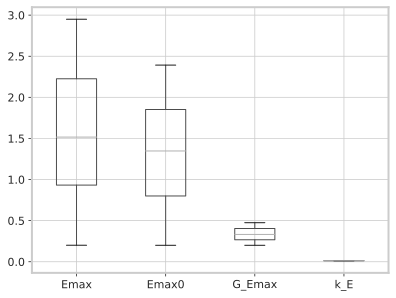

In [38]:
Ycomp.boxplot()

In [39]:
path = '/media/maousi/Data/tmp/simulation_LVAD_RPM{}_Pulse_T30_N2000_2020_04_26/'

In [40]:
Y = []
for rpm in [4000, 5000, 6000]:
    tmp = pd.read_csv(path.format(rpm) + 'parameters.txt')
    tmp.drop('n', axis=1, inplace=True)
    tmp['RPM'] = rpm
    
    Y.append(tmp)
Y = pd.concat(Y, ignore_index=True)

In [41]:
cols = [c for c in Y.columns if c != 'RPM']

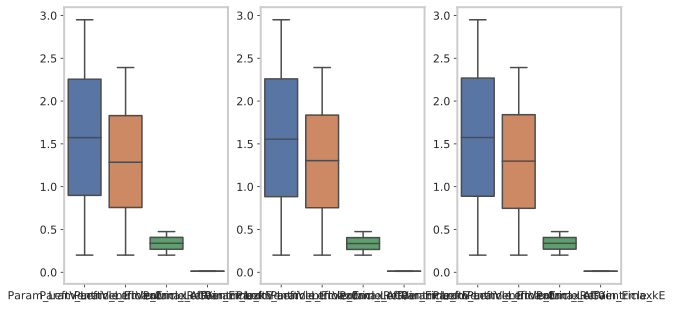

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i,rpm in enumerate([4000, 5000, 6000]):
    sns.boxplot(data=Y.loc[Y.RPM == rpm, cols] , ax=ax[i])

# Mean pressure of whole data

In [43]:
def compute_subset_mean_pressure(path, file_format, idxs):
    res = []
    for i in idxs:
        res.append(compute_mean(path + file_format.format(i), 'SystemicArteries.PC', 20.0, 30.0))
        
        if i % 200 == 0:
            print(i, end=' ')
    
    return res

In [44]:
path = '/media/maousi/Data/tmp/simulation_LVAD_RPM4000_Pulse_T30_N2000_2020_04_26/outputs/'
file = 'Ursino1998Model_VAD2_output_{}.mat'

In [45]:
res4000 = compute_subset_mean_pressure(path, file, range(10000))

0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 3800 4000 4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 6200 6400 6600 6800 7000 7200 7400 7600 7800 8000 8200 8400 8600 8800 9000 9200 9400 9600 9800 

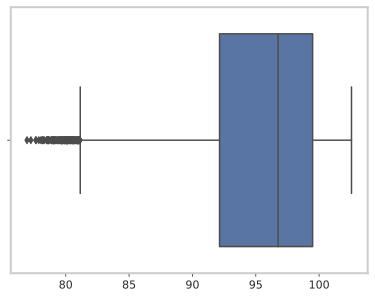

In [46]:
sns.boxplot(res4000)

In [47]:
path = '/media/maousi/Data/tmp/simulation_LVAD_RPM6000_Pulse_T30_N2000_2020_04_26/outputs/'
res6000 = compute_subset_mean_pressure(path, file, range(10000))

0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 3800 4000 4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 6200 6400 6600 6800 7000 7200 7400 7600 7800 8000 8200 8400 8600 8800 9000 9200 9400 9600 9800 

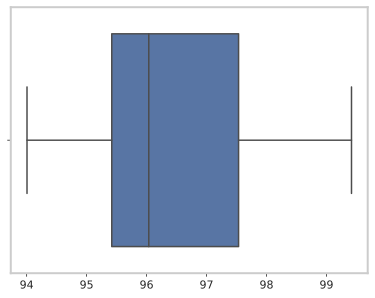

In [48]:
sns.boxplot(res6000)

In [49]:
path = '/media/maousi/Data/tmp/simulation_LVAD_RPM5000_Pulse_T30_N2000_2020_04_26/outputs/'
file = 'Ursino1998Model_VAD2_output_{}.mat'

In [50]:
res = compute_subset_mean_pressure(path, range(10000))

TypeError: compute_subset_mean_pressure() missing 1 required positional argument: 'idxs'

In [ ]:
sns.boxplot(res)

## Recheck DNN test data

In [ ]:
path_ = '/media/maousi/Data/tmp/simulation_LVAD_RPM{}_Pulse_T30_N2000_2020_04_26/dnn_test_2020_05_08/outputs/'
file_exact = 'Ursino1998Model_VAD2_output_{}_exact.mat'

In [ ]:
path = path_.format(6000)
res = compute_subset_mean_pressure(path, file_exact, range(500))

In [ ]:
sns.boxplot(res)

In [ ]:
path = path_.format(4000)
res = compute_subset_mean_pressure(path, file_exact, range(500))
sns.boxplot(res)

In [ ]:
file_pred = 'Ursino1998Model_VAD2_output_{}_predicted.mat'
res = compute_subset_mean_pressure(path, file_pred, range(500))
sns.boxplot(res)